# 1. Problem Definition and Requirements

**Objective:**  
Predict travel time (duration in seconds) for ride trips given start and end locations (specified in WGS84 coordinates) and a departure datetime.

**Datasets:**  
- **train.csv:** Contains columns:
  - `row_id`, `start_lng`, `start_lat`, `end_lng`, `end_lat`, `datetime`, `duration`
- **test.csv:** Contains columns:
  - `row_id`, `start_lng`, `start_lat`, `end_lng`, `end_lat`, `datetime`

**Evaluation Metric:**  
Root Mean Squared Error (RMSE) computed as:  
```python
RMSE = sqrt(mean_squared_error(prediction, ground_truth))

# 2. Data Ingestion and Exploration

In this step, we load the training and test datasets, inspect their structure, and conduct initial exploratory analysis to understand the underlying data characteristics. This exploration helps identify potential issues (such as missing values and outliers) and informs subsequent feature engineering and modeling steps.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from scipy.stats import skew, randint, uniform

from pyproj import Geod

from sklearn.metrics.pairwise import haversine_distances
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    cross_val_score
)


import folium
from folium.plugins import FastMarkerCluster

## Data Loading

- Read the `train.csv` and `test.csv` files using pandas.
- Parse the `datetime` column into datetime objects for easier temporal manipulation later.

In [2]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])
test = pd.read_csv('test.csv', parse_dates=['datetime'])

## Initial Inspection

- Display the first few rows of each dataset with `.head()` to get an overview.
- Use `.info()` to review data types and non-null counts, which aids in detecting missing or inconsistent data.
- Generate summary statistics with `.describe()` to understand the distribution, central tendency, and spread of numerical features.

In [3]:
train.head()

row_id   start_lng  start_lat     end_lng    end_lat            datetime  \
0       0  -73.783279  40.644718  -73.963799  40.681320 2015-01-09 00:51:48   
1       1 -122.422385  37.789408 -122.419890  37.766692 2012-09-14 01:46:00   
2       2  -73.885292  40.773060  -74.000076  40.761360 2015-04-19 20:26:57   
3       3 -122.401603  37.788975 -122.410958  37.796447 2012-09-03 23:48:00   
4       4  -74.008728  40.714317  -74.006432  40.731720 2015-01-21 12:14:45   

   duration  
0    1815.0  
1     300.0  
2    2620.0  
3     360.0  
4     582.0

In [4]:
test.head()

row_id   start_lng  start_lat     end_lng    end_lat            datetime
0       0  -74.001488  40.726170  -73.962097  40.764500 2015-06-27 23:58:40
1       1 -122.454077  37.774170 -122.428070  37.777023 2012-09-10 01:32:00
2       2  -73.976753  40.751575  -73.789917  40.646965 2015-09-26 11:24:54
3       3 -122.405967  37.778165 -122.430198  37.759545 2012-09-03 05:21:00
4       4  -73.988197  40.750187  -73.872711  40.774292 2015-02-12 09:48:39

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146001 entries, 0 to 146000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   row_id     146001 non-null  int64         
 1   start_lng  145601 non-null  float64       
 2   start_lat  146001 non-null  float64       
 3   end_lng    146001 non-null  float64       
 4   end_lat    145401 non-null  float64       
 5   datetime   146001 non-null  datetime64[ns]
 6   duration   146001 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 7.8 MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   row_id     30000 non-null  int64         
 1   start_lng  30000 non-null  float64       
 2   start_lat  30000 non-null  float64       
 3   end_lng    30000 non-null  float64       
 4   end_lat    30000 non-null  float64       
 5   datetime   30000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.4 MB


In [7]:
train.describe()

row_id      start_lng      start_lat        end_lng  \
count  146001.000000  145601.000000  146001.000000  146001.000000   
mean    73000.000000     -86.465695      39.913703     -87.177163   
min         0.000000    -122.515832      37.459648    -122.634420   
25%     36500.000000    -122.393532      37.798430    -122.392458   
50%     73000.000000     -73.989830      40.741089     -73.988754   
75%    109500.000000     -73.974190      40.762104     -73.971245   
max    146000.000000      74.100212      40.994354     -50.336068   
std     42147.002663      25.468467       1.339508      22.225753   

             end_lat                       datetime       duration  
count  145401.000000                         146001  146001.000000  
mean       39.922772  2014-09-12 22:40:34.780385280    1063.222314  
min        37.225640            2012-09-01 00:00:00       0.000000  
25%        37.800318            2012-09-13 21:16:00     382.000000  
50%        40.740990            2015-04-16 03:37:24     631.000000  
75%        40.762669            2015-08-19 00:46:17    1020.000000  
max        41.005390            2016-01-01 03:49:39   42168.000000  
std         1.336437                            NaN    3305.905829

## Missing Values Analysis

- Identify missing data with `.isnull().sum()`, ensuring data integrity and determining if imputation or cleaning is required.

In [8]:
train.isnull().sum()

row_id         0
start_lng    400
start_lat      0
end_lng        0
end_lat      600
datetime       0
duration       0
dtype: int64

In [9]:
train['missing_coords'] = train[['start_lng', 'end_lat']].isnull().any(axis=1)
missing_count = train['missing_coords'].sum()
total_rows = train.shape[0]
print(f"Missing coordinate rows: {missing_count} out of {total_rows}")
print("\nSummary statistics for 'duration' by missing indicator:")
print(train.groupby('missing_coords')['duration'].describe())

Missing coordinate rows: 1000 out of 146001

Summary statistics for 'duration' by missing indicator:
                   count         mean          std    min    25%    50%  \
missing_coords                                                            
False           145001.0  1065.804932  3316.873211    0.0  383.0  631.0   
True              1000.0   688.740000   506.019830  120.0  360.0  600.0   

                   75%      max  
missing_coords                   
False           1020.0  42168.0  
True             840.0   6180.0  


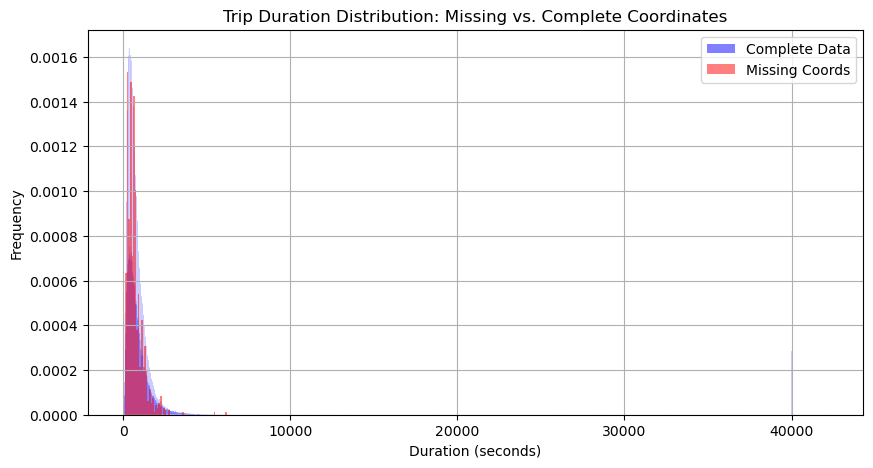

In [10]:
plt.figure(figsize=(10, 5))
plt.hist(train.loc[~train['missing_coords'], 'duration'], bins='auto', alpha=0.5, label='Complete Data', color='blue', histtype='stepfilled', density=True)
plt.hist(train.loc[train['missing_coords'], 'duration'], bins='auto', alpha=0.5, label='Missing Coords', color='red', histtype='stepfilled', density=True)
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Trip Duration Distribution: Missing vs. Complete Coordinates")
plt.legend()
plt.grid()
plt.show()

### Handling Missing Values  
- For critical features like `start_lng`, `start_lat`, `end_lng`, and `end_lat`, missing values are not acceptable. Rows with missing values in these columns are dropped.
- Since the distribution of missing values between the complete data and the missing data is similar and the share of missing values is small, dropping rows with missing values is a reasonable approach.

In [12]:
train.dropna(subset=['start_lng', 'start_lat', 'end_lng', 'end_lat'], inplace=True)

## Exploratory Visualizations

- Trip Duration Distribution: A histogram is plotted to understand the distribution of trip durations, highlighting skewness or outliers.
- Geospatial Distribution: Plots in a map of the start and end locations reveal the cities where the duration is estimated.
- Temporal Patterns: Extracting the hour from the `datetime` field and plotting trip counts by hour, day of the week, month and year.


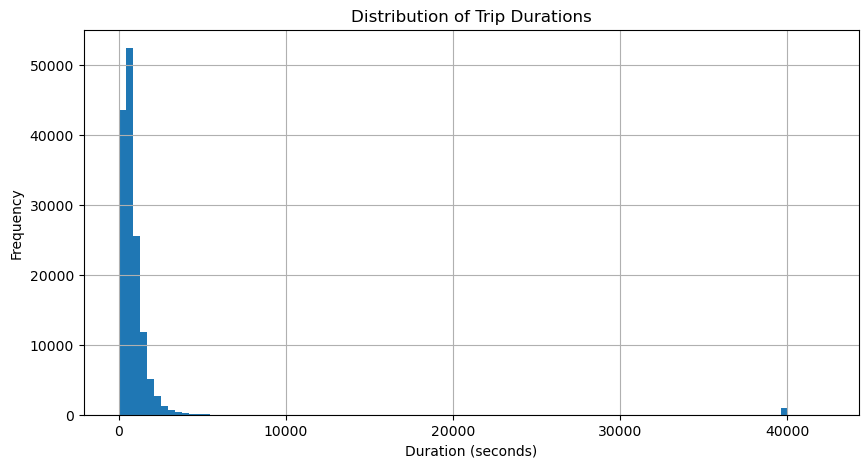

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(train['duration'], bins=100)
plt.title("Distribution of Trip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

We can observe outliers at around 40000 seconds. We can also notice that most values fall below 5000 seconds. We can further investigate these outliers.

### IQR-based outlier detection

In [14]:
q1 = train['duration'].quantile(0.25)
q3 = train['duration'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

Lower bound: -572.5
Upper bound: 1975.5


Converting to minutes, 1975.5 seconds is equivalent to approximately 32.93 minutes. For trips inside a city, this maximum duration seems low. We are going to explore other outlier detection methods.

In [15]:
outliers = train[(train['duration'] < lower_bound) | (train['duration'] > upper_bound)]
outlier_share = outliers.shape[0] / train.shape[0]
print(f"Share of trips with duration outliers: {outlier_share:.2f}")

Share of trips with duration outliers: 0.05


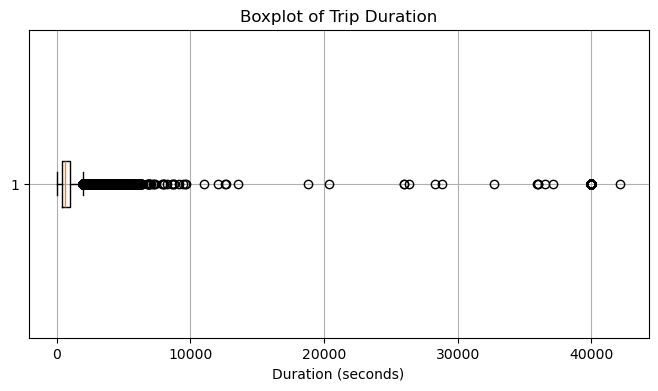

In [16]:
plt.figure(figsize=(8, 4))
plt.boxplot(train['duration'], vert=False)
plt.title("Boxplot of Trip Duration")
plt.xlabel("Duration (seconds)")
plt.grid()
plt.show()

### Percentile-based outlier detection

In [17]:
lower_limit = train['duration'].quantile(0.01)
upper_limit = train['duration'].quantile(0.99)

print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

train = train[(train['duration'] >= lower_limit) & (train['duration'] <= upper_limit)]

Lower limit: 83.0
Upper limit: 4049.0


The percentile-based method yields a higher upper bound of 4049 seconds, which is equal to 1 hour and 7 minutes. This value seems more reasonable for a city trip. We will use this threshold to filter out outliers.

In [18]:
mean_coords = [train['start_lat'].mean(), train['start_lng'].mean()]
m = folium.Map(location=mean_coords, zoom_start=12)

FastMarkerCluster(data=train[['start_lat', 'start_lng']].values).add_to(m)

m

We can notice that there are incorrect longitude values in the dataset. These incorrect values have longitude values at around 75, however we would expect these values to be around -75. We will correct these values.

In [19]:
train.loc[train['start_lng'] > 0, 'start_lng'] *= -1

In [20]:
mean_coords = [train['end_lat'].mean(), train['end_lng'].mean()]
m = folium.Map(location=mean_coords, zoom_end=12)

FastMarkerCluster(data=train[['end_lat', 'end_lng']].values).add_to(m)

m

We can also notice that there are destinations in the ocean. These rows will be removed from the dataset.

In [21]:
train = train[train['end_lng'] < -60]

### Feature histograms

In [22]:
train['start_city'] = 'SF'
train.loc[train['start_lng'] > -100, 'start_city'] = 'NY'

train['end_city'] = 'SF'
train.loc[train['end_lng'] > -100, 'end_city'] = 'NY'

train['same_city'] = train['start_city'] == train['end_city']

print(train['same_city'].value_counts())
print("\nNumber of trips:", train.shape[0])

same_city
True    139628
Name: count, dtype: int64

Number of trips: 139628


In [23]:
test['start_city'] = 'SF'
test.loc[test['start_lng'] > -100, 'start_city'] = 'NY'

test['end_city'] = 'SF'
test.loc[test['end_lng'] > -100, 'end_city'] = 'NY'

test['same_city'] = test['start_city'] == test['end_city']

print(test['same_city'].value_counts())
print("\nNumber of trips:", test.shape[0])

same_city
True    30000
Name: count, dtype: int64

Number of trips: 30000


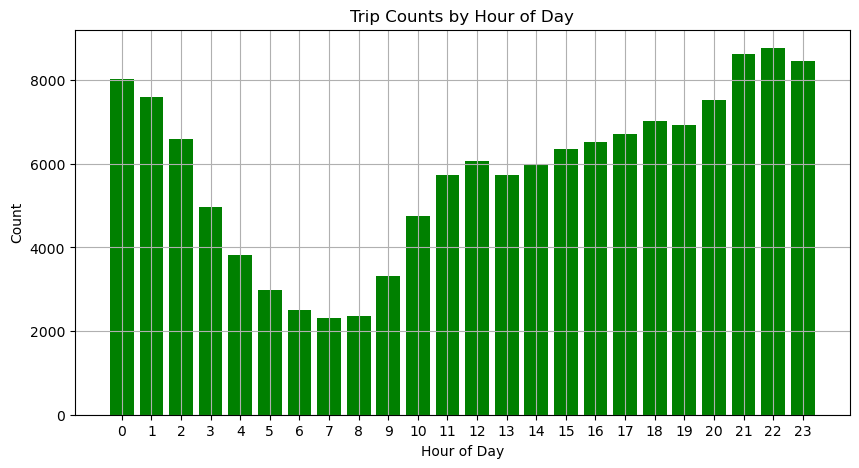

In [24]:
train['hour'] = train['datetime'].dt.hour
hour_counts = train['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(hour_counts.index, hour_counts.values, color='green')
plt.title("Trip Counts by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.xticks(range(0, 24))
plt.grid()
plt.show()

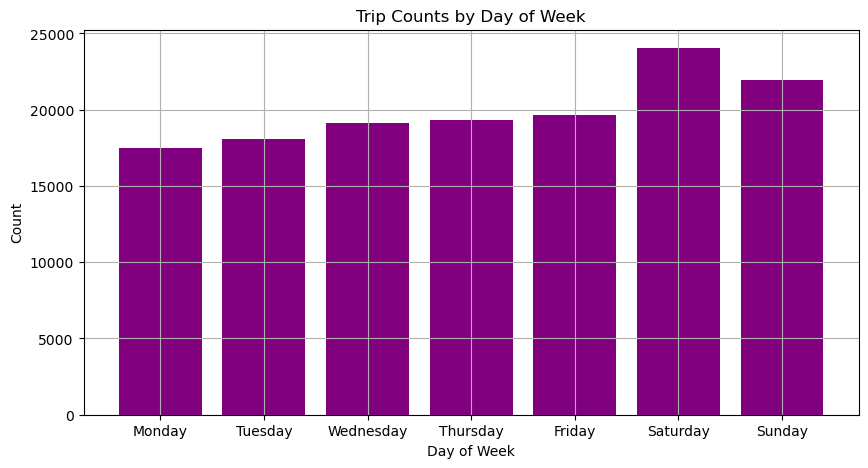

In [25]:
train['dayofweek'] = train['datetime'].dt.dayofweek
day_counts = train['dayofweek'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(day_counts.index, day_counts.values, color='purple')
plt.title("Trip Counts by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid()
plt.show()

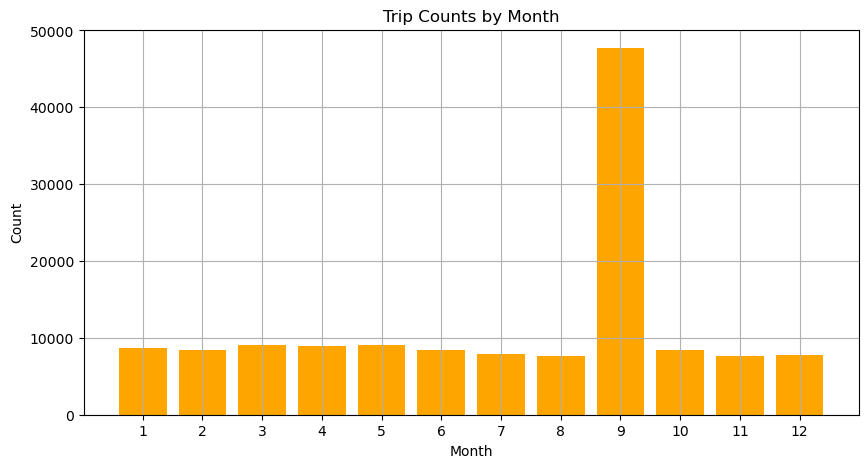

In [26]:
train['month'] = train['datetime'].dt.month
month_counts = train['month'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(month_counts.index, month_counts.values, color='orange')
plt.title("Trip Counts by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(range(1, 13))
plt.grid()
plt.show()

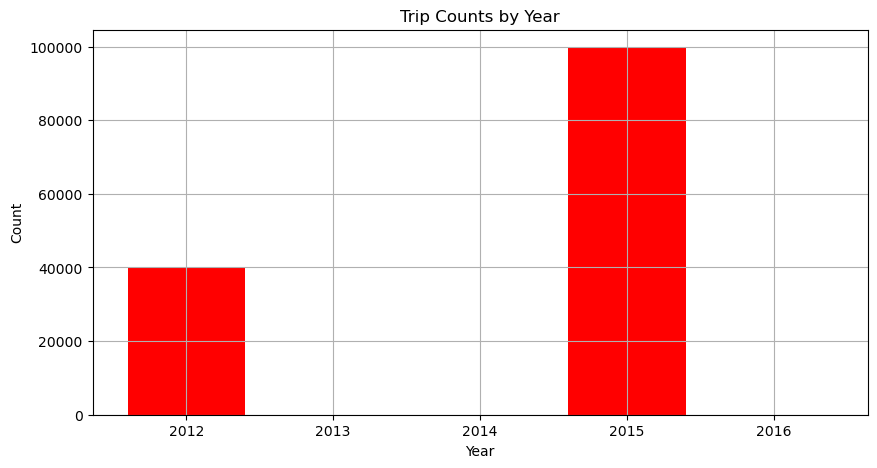

In [27]:
train['year'] = train['datetime'].dt.year
year_counts = train['year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(year_counts.index, year_counts.values, color='red')
plt.title("Trip Counts by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid()
plt.show()

In [28]:
train.drop(columns=['hour', 'dayofweek', 'month', 'year', 'same_city'], inplace=True)

# 3. Data Cleaning and Preprocessing

In this step, we ensure that our data is clean and consistent before moving forward with feature engineering and model training.

## Removing Duplicates

- Duplicate rows can bias model training. We remove any duplicated entries.

In [29]:
print("Initial training data shape:", train.shape)
train = train.drop_duplicates()
print("After removing duplicates:", train.shape)

Initial training data shape: (139628, 10)
After removing duplicates: (139628, 10)


# 4. Feature Engineering

- In this step, we transform the raw data into more informative features that can enhance the predictive power of our models.

## Geospatial Features
- Haversine Distance: Calculates the great-circle distance between the start and end coordinates. This feature captures the physical distance traveled.
- Bearing: Computes the directional angle from the start point to the end point, which might capture travel dynamics related to road networks.

In [32]:
R = 6371

def compute_haversine(row):
    start = np.radians([row['start_lat'], row['start_lng']])
    end = np.radians([row['end_lat'], row['end_lng']])
    distance_rad = haversine_distances([start], [end])
    return distance_rad[0][0] * R

geod = Geod(ellps='WGS84')

def compute_bearing(row):
    azimuth, _, _ = geod.inv(row['start_lng'], row['start_lat'], row['end_lng'], row['end_lat'])
    return (azimuth + 360) % 360

train['distance_km'] = train.apply(compute_haversine, axis=1)
train['bearing'] = train.apply(compute_bearing, axis=1)

test['distance_km'] = test.apply(compute_haversine, axis=1)
test['bearing'] = test.apply(compute_bearing, axis=1)

## Temporal Features:
- Hour of Day: Extracted from the datetime to capture peak and off-peak travel times.
- Day of Week: Helps identify weekly patterns in travel behavior.
- Month: Can capture seasonal variations in travel times.
- Given the cyclical nature of time (e.g., 23:00 is closer to 00:00 than to 20:00), we encode these features using sine and cosine transformations to preserve their cyclical nature.

In [33]:
train['hour'] = train['datetime'].dt.hour
train['day_of_week'] = train['datetime'].dt.dayofweek
train['month'] = train['datetime'].dt.month

test['hour'] = test['datetime'].dt.hour
test['day_of_week'] = test['datetime'].dt.dayofweek
test['month'] = test['datetime'].dt.month

In [34]:
def cyclical_transform(series, period):
    sin_component = np.sin(2 * np.pi * series / period)
    cos_component = np.cos(2 * np.pi * series / period)
    return pd.DataFrame({f'{series.name}_sin': sin_component, f'{series.name}_cos': cos_component})

hour_cyclical = cyclical_transform(train['hour'], 24)
day_cyclical = cyclical_transform(train['day_of_week'], 7)
month_cyclical = cyclical_transform(train['month'], 12)

train = pd.concat([train, hour_cyclical, day_cyclical, month_cyclical], axis=1)

hour_cyclical_test = cyclical_transform(test['hour'], 24)
day_cyclical_test = cyclical_transform(test['day_of_week'], 7)
month_cyclical_test = cyclical_transform(test['month'], 12)

test = pd.concat([test, hour_cyclical_test, day_cyclical_test, month_cyclical_test], axis=1)

In [ ]:
train.to_csv('train_cleaned.csv', index=True)
test.to_csv('test_cleaned.csv', index=True)

### Open Source Routing Machine (OSRM) Features

- OSRM is a routing service that provides estimated travel times and distances between locations. We can leverage this data to create additional features that capture road network characteristics.
- These operations have been performed in the `osrm_distances_times.ipynb` notebook.

In [37]:
train_osrm = pd.read_csv('train_osrm.csv', index_col=0)
test_osrm = pd.read_csv('test_osrm.csv', index_col=0)

train = train.merge(train_osrm, how='left', left_index=True, right_index=True)
test = test.merge(test_osrm, how='left', left_index=True, right_index=True)

train.dropna(axis=0, inplace=True)

In [ ]:
train['start_city'] = train['start_city'].map({'NY': 0, 'SF': 1})
test['start_city'] = test['start_city'].map({'NY': 0, 'SF': 1})

# 5. Feature Selection

In this step, we evaluate our engineered and raw features to identify those that are most predictive of the target (trip duration) and remove redundant or non-informative variables.

In [ ]:
features = ['start_lng', 'start_lat', 'end_lng', 'end_lat', 'start_city', 'distance_km', 'bearing',
            'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
            'osrm_distance', 'osrm_duration']

X = train[features]
y = train['duration']

test = test[features]

## Correlation Analysis:  
- We compute a correlation matrix to assess linear relationships among the features and with the target variable. This helps us spot multicollinearity and understand which features are most strongly associated with trip duration.

<Figure size 1000x800 with 0 Axes>

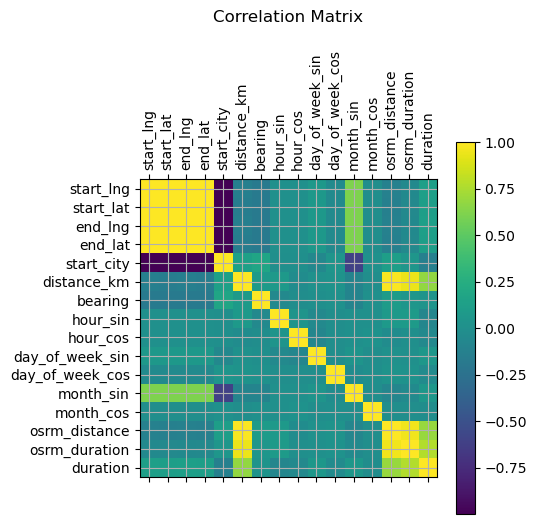

In [ ]:
corr_matrix = train[features + ['duration']].corr()

plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix)#, fignum=1)
plt.title("Correlation Matrix", pad=20)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.grid()
plt.show()

In [ ]:
features = ['end_lng', 'end_lat', 'distance_km', 'bearing', 'hour_sin', 'hour_cos', 'day_of_week_sin',
            'day_of_week_cos', 'month_sin', 'month_cos']

features = ['start_lng', 'start_city', 'distance_km', 'bearing','hour_sin', 'hour_cos', 'day_of_week_sin',
            'day_of_week_cos', 'month_sin', 'month_cos', 'osrm_distance', 'osrm_duration']

X = X[features]
test = test[features]

# Step 6: Progressive Model Selection

In this step, we start with a simple baseline model and progressively try more complex models if the initial performance is unsatisfactory.

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 1)Linear Regression
# 2) Ridge Regression
# 3) Lasso Regression
# 4) ElasticNet Regression
# 5) Bayesian Ridge Regression
# 6) Decision Tree Regression
# 7) Random Forest Regression
# 8) Gradient Boosting Regression
# 9) XGBoost Regression
# 10) LightGBM Regression
# 11) CatBoost Regression
# 12) AdaBoost Regression
# 13) HistGradientBoosting Regression
# 14) K-Nearest Neighbors Regression
# 15) Support Vector Regression (SVR)

## Baseline Model (Simple Model):  
- We begin with a basic linear regression model. This model is quick to train, easy to interpret, and provides a baseline performance level.

In [ ]:
linear_regression = LinearRegression()
baseline_model = linear_regression
baseline_model.fit(X_train, y_train)
baseline_scores = cross_val_score(
    baseline_model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
baseline_rmse = np.sqrt(-baseline_scores)
print(f"Baseline Linear Regression RMSE: Mean = {baseline_rmse.mean():.2f}, Std = {baseline_rmse.std():.2f}")

Evaluating Baseline Model: Linear Regression


Baseline Linear Regression RMSE: Mean = 334.06, Std = 3.41


In [47]:
baseline_predictions = baseline_model.predict(X_val)
baseline_mse = np.mean((baseline_predictions - y_val) ** 2)
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline Linear Regression RMSE on Test Set: {baseline_rmse:.2f}")

Baseline Linear Regression RMSE on Test Set: 328.81


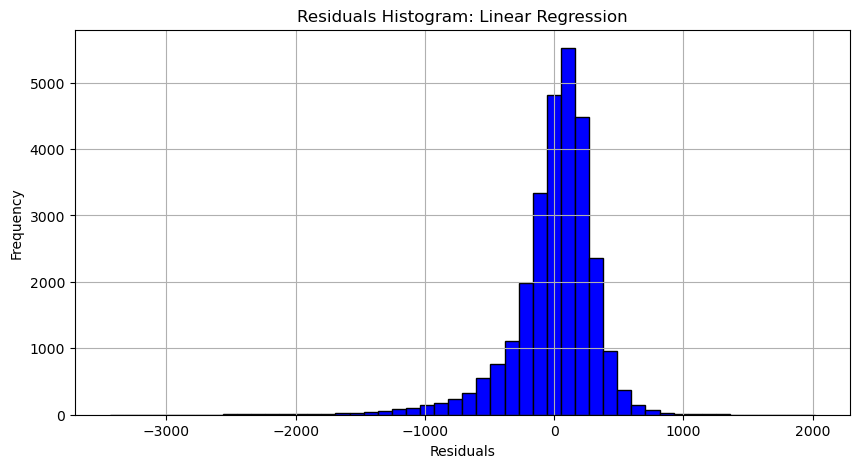

Skewness of Residuals: -1.79


In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(baseline_predictions - y_val, bins=50, color='blue', edgecolor='black')
plt.title("Residuals Histogram: Linear Regression")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid()
plt.show()

residual_skew = skew(baseline_predictions - y_val)
print(f"Skewness of Residuals: {residual_skew:.2f}")

## Progressive Complexity:  

- To try to improve the performance, we can then try more sophisticated models, such as Random Forests, SVR, or XGBoost. These models can capture non-linearities and interactions better but come at the cost of increased complexity and tuning effort.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rf_rmse = np.sqrt(-rf_scores)
print(f"Random Forest RMSE: Mean = {rf_rmse.mean():.2f}, Std = {rf_rmse.std():.2f}")


Evaluating Complex Model: Random Forest Regressor
Random Forest RMSE: Mean = 285.23, Std = 2.62


In [ ]:
def predict_and_upload(model, test_data, message):
    predictions = model.predict(test_data)
    with open('predictions.csv', 'w') as f:
        f.write("row_id,duration\n")
        for i, duration in enumerate(predictions):
            f.write(f"{i},{duration}\n")
    !kaggle competitions submit -c ce263n-hw4 -f predictions.csv -m "{message}"

In [ ]:
predict_and_upload(
    rf_model,
    test,
    "aaaa"
)

100%|█████████████████████████████████████████| 368k/368k [00:00<00:00, 551kB/s]
Successfully submitted to CE263N Assignment 4

In [69]:
def nested_cv_search(X_train, y_train, search_method, n_iter):

    if search_method == 'grid':
        param_grid = {
            'n_estimators': [100, 200, 300, 400, 500, 600, 700],
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
            'reg_lambda': [0.1, 0.5, 1.0],
            'subsample': [0.6, 0.8, 1.0],
        }
        search_cv = GridSearchCV
        search_params = param_grid
    elif search_method == 'random':
        param_dist = {
            'n_estimators': randint(50, 1000),
            'max_depth': randint(3, 15),
            'learning_rate': uniform(0.001, 0.2),
            'reg_lambda': uniform(0.1, 2.0),
            'subsample': uniform(0.5, 0.5),
        }
        search_cv = RandomizedSearchCV
        search_params = param_dist
    else:
        raise ValueError("search_method must be either 'grid' or 'random'")


    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    if search_method == 'grid':
        search = search_cv(
            estimator=xgb_model,
            param_grid=search_params,
            scoring='neg_mean_squared_error',
            cv=inner_cv,
            n_jobs=-1
        )
    elif search_method == 'random':
        search = search_cv(
            estimator=xgb_model,
            param_distributions=search_params,
            scoring='neg_mean_squared_error',
            cv=inner_cv,
            n_jobs=-1,
            random_state=42,
            n_iter=n_iter
        )

    nested_scores = cross_val_score(
        search,
        X_train,
        y_train,
        scoring='neg_mean_squared_error',
        cv=outer_cv,
        n_jobs=-1
    )

    rmse_scores = np.sqrt(-nested_scores)

    print(f"Average MSE: {rmse_scores.mean()} +/- {rmse_scores.std()}")

In [ ]:
nested_cv_search(
    X_train,
    y_train,
    search_method='random',
    n_iter=50
)#11min

Average MSE: 273.9366380336502 +/- 4.260526675230157


In [ ]:
nested_cv_search(
    X_train,
    y_train,
    search_method='grid',
    n_iter=50
)

In [ ]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=9,
    learning_rate=0.045,
    n_estimators=500,
    reg_lambda=0.5,
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_scores = cross_val_score(
    xgb_model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
xgb_rmse = np.sqrt(-xgb_scores)
print(f"XGBoost RMSE: Mean = {xgb_rmse.mean():.2f}, Std = {xgb_rmse.std():.2f}")

xgb_predictions = xgb_model.predict(X_val)
xgb_mse = np.mean((xgb_predictions - y_val) ** 2)
xgb_rmse = np.sqrt(xgb_mse)
print(f"XGBoost RMSE on Test Set: {xgb_rmse:.2f}")

XGBoost RMSE: Mean = 276.85, Std = 3.39
XGBoost RMSE on Test Set: 270.86


In [60]:
predict_and_upload(
    xgb_model,
    test,
    "xbgoost"
)

100%|█████████████████████████████████████████| 686k/686k [00:00<00:00, 798kB/s]
Successfully submitted to CE263N Assignment 4